In [ ]:
#!pip install qlearnkit['pennylane']
#!pip install --upgrade scipy pennylane
#!pip install pennylane
#!pip install --upgrade numpy pennylane
#!pip install pennylane-lightning
#!pip install --upgrade torch



In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class QLSTM(nn.Module):

    def custom_encoding(self, inputs, wires):
        # Apply Hadamard to each qubit to create an unbiased initial state
        for wire in range(self.n_qubits):
            qml.Hadamard(wires=wire)

        qml.templates.AngleEmbedding(torch.arctan(inputs), rotation='Y', wires=wires)
        qml.templates.AngleEmbedding(torch.arctan(inputs ** 2), rotation='Z', wires=wires)

    def custom_entangler_layer(self, weights, wires):
        for l in range(self.n_qlayers):  # Repeat the sequence twice
            # Apply CNOTs for the specified entanglement structure
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[3, 0])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])

            # Apply general rotation for each qubit
            for i, wire in enumerate(wires):
                qml.Rot(*weights[l, i, :], wires=wire)

    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=4,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = list(range(self.n_qubits))
        self.wires_input = list(range(self.n_qubits))
        self.wires_update = list(range(self.n_qubits))
        self.wires_output = list(range(self.n_qubits))
        self.wires_hidden = list(range(self.n_qubits))
        self.wires_output_pre = list(range(self.n_qubits))

        self.dev_forget = qml.device('default.qubit', wires=self.wires_forget)
        self.dev_input = qml.device('default.qubit', wires=self.wires_input)
        self.dev_update = qml.device('default.qubit', wires=self.wires_update)
        self.dev_output = qml.device('default.qubit', wires=self.wires_output)
        self.dev_hidden = qml.device('default.qubit', wires=self.wires_hidden)
        self.dev_output_pre = qml.device('default.qubit', wires=self.wires_output_pre)

        def _circuit_forget(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_forget)
            self.custom_entangler_layer(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_input)
            self.custom_entangler_layer(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_update)
            self.custom_entangler_layer(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output)
            self.custom_entangler_layer(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        def _circuit_hidden(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_hidden)
            self.custom_entangler_layer(weights, wires=self.wires_hidden)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_hidden]
        self.qlayer_hidden = qml.QNode(_circuit_hidden, self.dev_hidden, interface="torch")

        def _circuit_output_pre(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output_pre)
            self.custom_entangler_layer(weights, wires=self.wires_output_pre)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_pre]
        self.qlayer_output_pre = qml.QNode(_circuit_output_pre, self.dev_output_pre, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_qubits, 3)}
        print(f"weight_shapes = (n_qlayers, n_qubits, 3) = ({n_qlayers}, {n_qubits}, 3)")

        self.clayer_in = torch.nn.Linear(self.hidden_size + self.n_inputs, self.n_qubits)
        print("Initialized clayer_in weight shape:", self.clayer_in.weight.shape)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes),
            'hidden': qml.qnn.TorchLayer(self.qlayer_hidden, weight_shapes),
            'output_pre': qml.qnn.TorchLayer(self.qlayer_output_pre, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        self.swish = Swish()  #the Swish activation function here

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> Swish
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)
            v_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](v_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](v_t)))
            g_t = self.swish(self.clayer_out(self.VQC['update'](v_t)))  # Swish here
            c_t = (f_t * c_t) + (i_t * g_t)

            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](v_t)))
            h_t = self.VQC['hidden'](o_t * self.swish(c_t))  # Swish here
            y_tilde = self.VQC['output_pre'](o_t * self.swish(c_t))  # Swish here
            y_t = self.clayer_out(y_tilde)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

LSTM hidden layer size: 4
Number of qubits: 4
Training epochs: 500
Learning rate: 0.001
RMSprop alpha: 0.99
RMSprop eps: 1e-08
Sample size: 1000
Sequence length: 4
Input size: 3


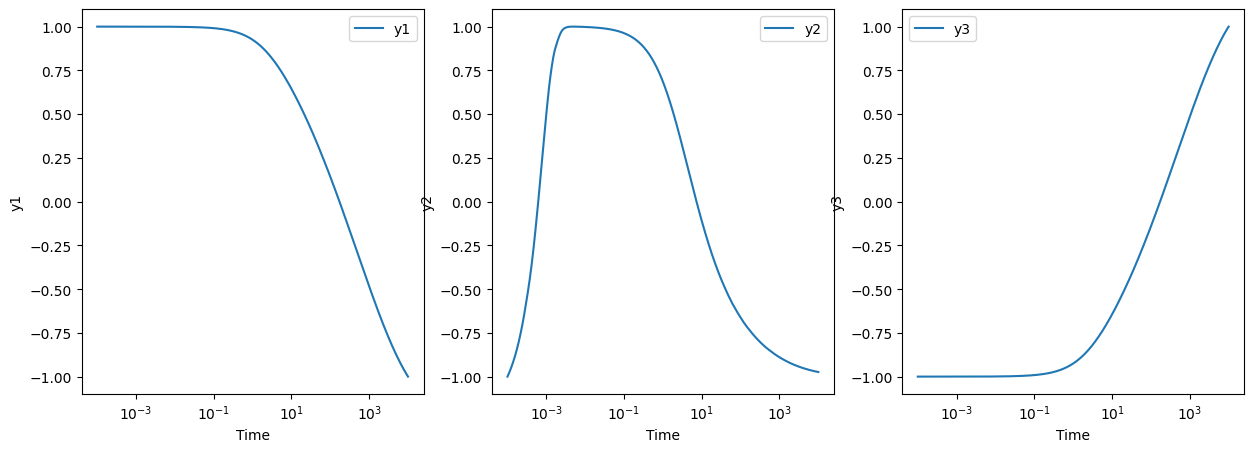

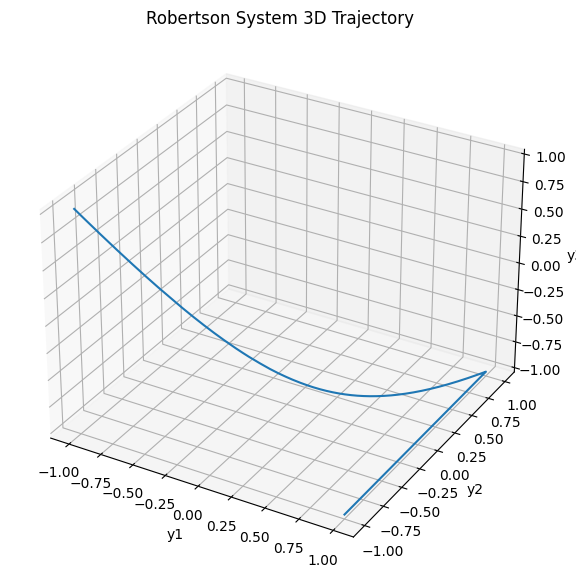

Epoch 1, Train Loss: 0.7379, Test Loss: 0.4041
Epoch 2, Train Loss: 0.5944, Test Loss: 0.3729
Epoch 3, Train Loss: 0.5012, Test Loss: 0.3443
Epoch 4, Train Loss: 0.4229, Test Loss: 0.3183
Epoch 5, Train Loss: 0.3541, Test Loss: 0.2950


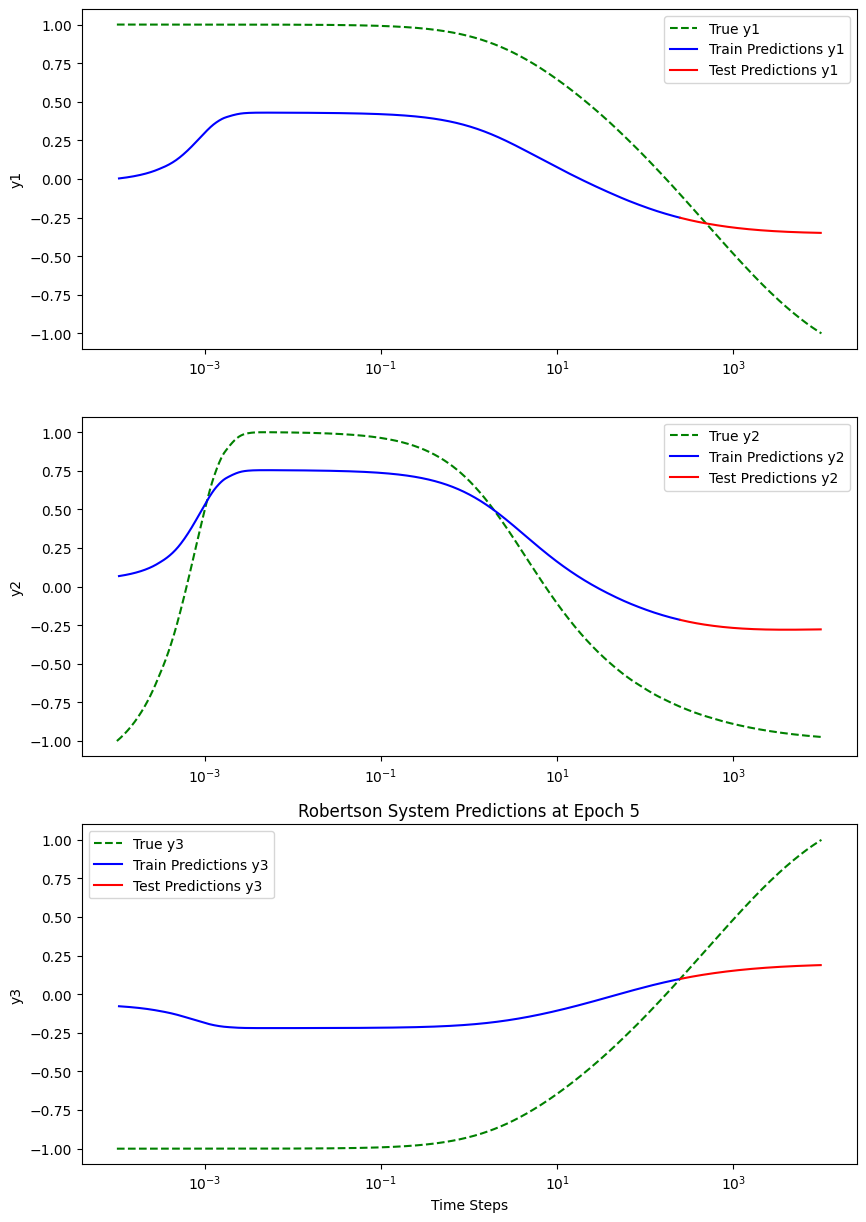

Epoch 6, Train Loss: 0.2938, Test Loss: 0.2744
Epoch 7, Train Loss: 0.2417, Test Loss: 0.2567
Epoch 8, Train Loss: 0.1976, Test Loss: 0.2419
Epoch 9, Train Loss: 0.1621, Test Loss: 0.2301
Epoch 10, Train Loss: 0.1338, Test Loss: 0.2204
Epoch 11, Train Loss: 0.1109, Test Loss: 0.2125
Epoch 12, Train Loss: 0.0924, Test Loss: 0.2058
Epoch 13, Train Loss: 0.0772, Test Loss: 0.2001
Epoch 14, Train Loss: 0.0648, Test Loss: 0.1954
Epoch 15, Train Loss: 0.0547, Test Loss: 0.1914
Epoch 16, Train Loss: 0.0466, Test Loss: 0.1881
Epoch 17, Train Loss: 0.0401, Test Loss: 0.1854
Epoch 18, Train Loss: 0.0348, Test Loss: 0.1833
Epoch 19, Train Loss: 0.0306, Test Loss: 0.1817
Epoch 20, Train Loss: 0.0272, Test Loss: 0.1804
Epoch 21, Train Loss: 0.0245, Test Loss: 0.1795
Epoch 22, Train Loss: 0.0224, Test Loss: 0.1788
Epoch 23, Train Loss: 0.0206, Test Loss: 0.1783
Epoch 24, Train Loss: 0.0192, Test Loss: 0.1779
Epoch 25, Train Loss: 0.0181, Test Loss: 0.1777
Epoch 26, Train Loss: 0.0171, Test Loss: 0.1

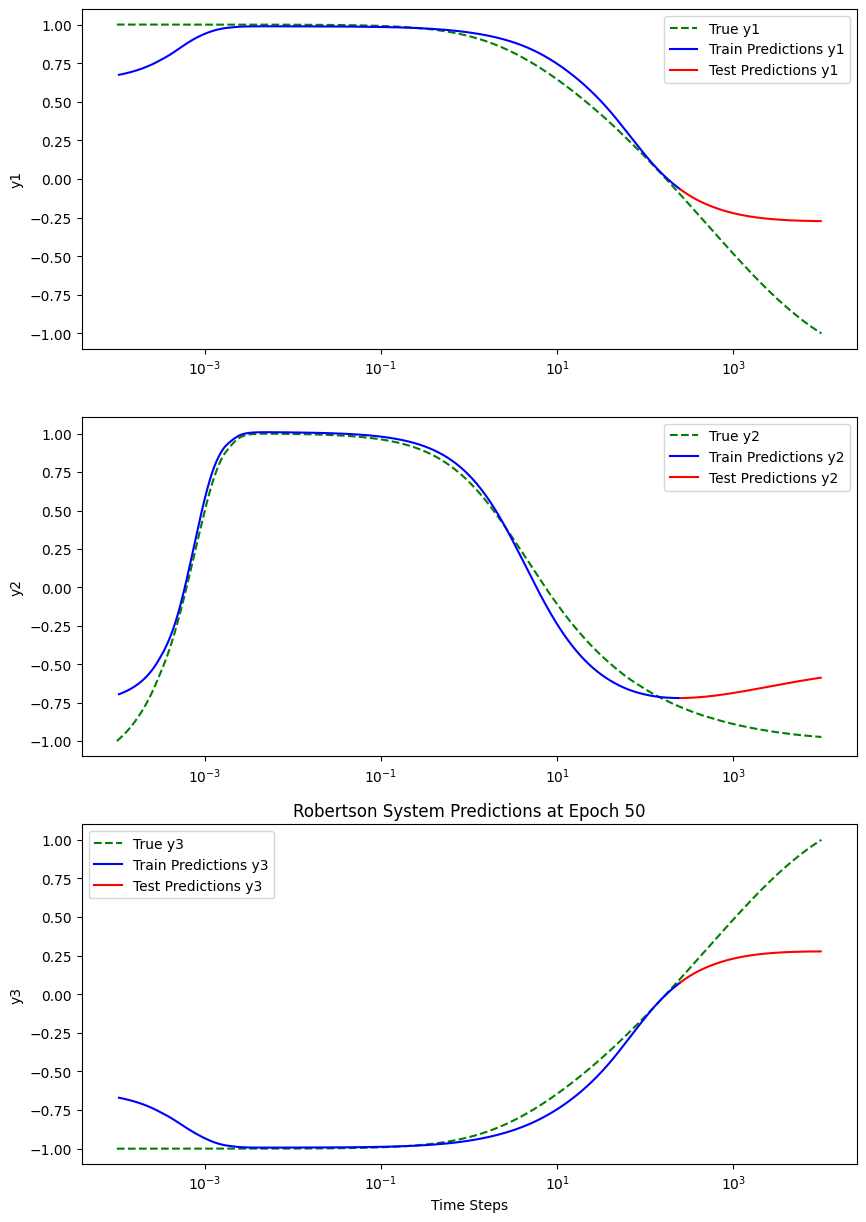

Epoch 51, Train Loss: 0.0085, Test Loss: 0.1746
Epoch 52, Train Loss: 0.0083, Test Loss: 0.1747
Epoch 53, Train Loss: 0.0081, Test Loss: 0.1749
Epoch 54, Train Loss: 0.0080, Test Loss: 0.1750
Epoch 55, Train Loss: 0.0078, Test Loss: 0.1752
Epoch 56, Train Loss: 0.0077, Test Loss: 0.1755
Epoch 57, Train Loss: 0.0075, Test Loss: 0.1757
Epoch 58, Train Loss: 0.0074, Test Loss: 0.1760
Epoch 59, Train Loss: 0.0072, Test Loss: 0.1762
Epoch 60, Train Loss: 0.0071, Test Loss: 0.1765
Epoch 61, Train Loss: 0.0069, Test Loss: 0.1768
Epoch 62, Train Loss: 0.0068, Test Loss: 0.1772
Epoch 63, Train Loss: 0.0067, Test Loss: 0.1775
Epoch 64, Train Loss: 0.0066, Test Loss: 0.1779
Epoch 65, Train Loss: 0.0064, Test Loss: 0.1782
Epoch 66, Train Loss: 0.0063, Test Loss: 0.1786
Epoch 67, Train Loss: 0.0062, Test Loss: 0.1790
Epoch 68, Train Loss: 0.0061, Test Loss: 0.1794
Epoch 69, Train Loss: 0.0060, Test Loss: 0.1798
Epoch 70, Train Loss: 0.0059, Test Loss: 0.1802
Epoch 71, Train Loss: 0.0058, Test Loss:

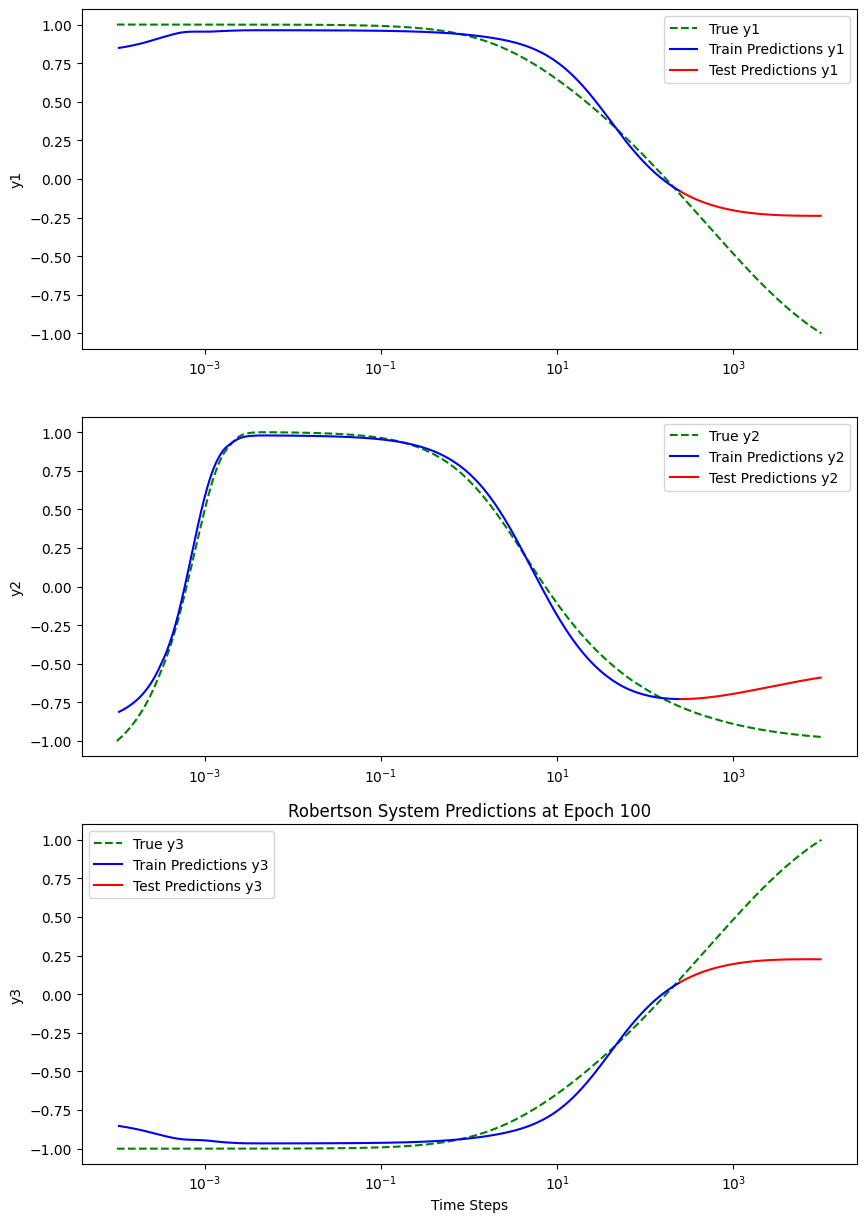

Epoch 101, Train Loss: 0.0034, Test Loss: 0.1953
Epoch 102, Train Loss: 0.0033, Test Loss: 0.1958
Epoch 103, Train Loss: 0.0033, Test Loss: 0.1962
Epoch 104, Train Loss: 0.0032, Test Loss: 0.1967
Epoch 105, Train Loss: 0.0032, Test Loss: 0.1971
Epoch 106, Train Loss: 0.0031, Test Loss: 0.1975
Epoch 107, Train Loss: 0.0031, Test Loss: 0.1979
Epoch 108, Train Loss: 0.0030, Test Loss: 0.1983
Epoch 109, Train Loss: 0.0029, Test Loss: 0.1987
Epoch 110, Train Loss: 0.0029, Test Loss: 0.1990
Epoch 111, Train Loss: 0.0028, Test Loss: 0.1994
Epoch 112, Train Loss: 0.0028, Test Loss: 0.1997
Epoch 113, Train Loss: 0.0027, Test Loss: 0.2001
Epoch 114, Train Loss: 0.0027, Test Loss: 0.2004
Epoch 115, Train Loss: 0.0026, Test Loss: 0.2007
Epoch 116, Train Loss: 0.0026, Test Loss: 0.2010
Epoch 117, Train Loss: 0.0025, Test Loss: 0.2013
Epoch 118, Train Loss: 0.0025, Test Loss: 0.2015
Epoch 119, Train Loss: 0.0024, Test Loss: 0.2018
Epoch 120, Train Loss: 0.0024, Test Loss: 0.2020
Epoch 121, Train Los

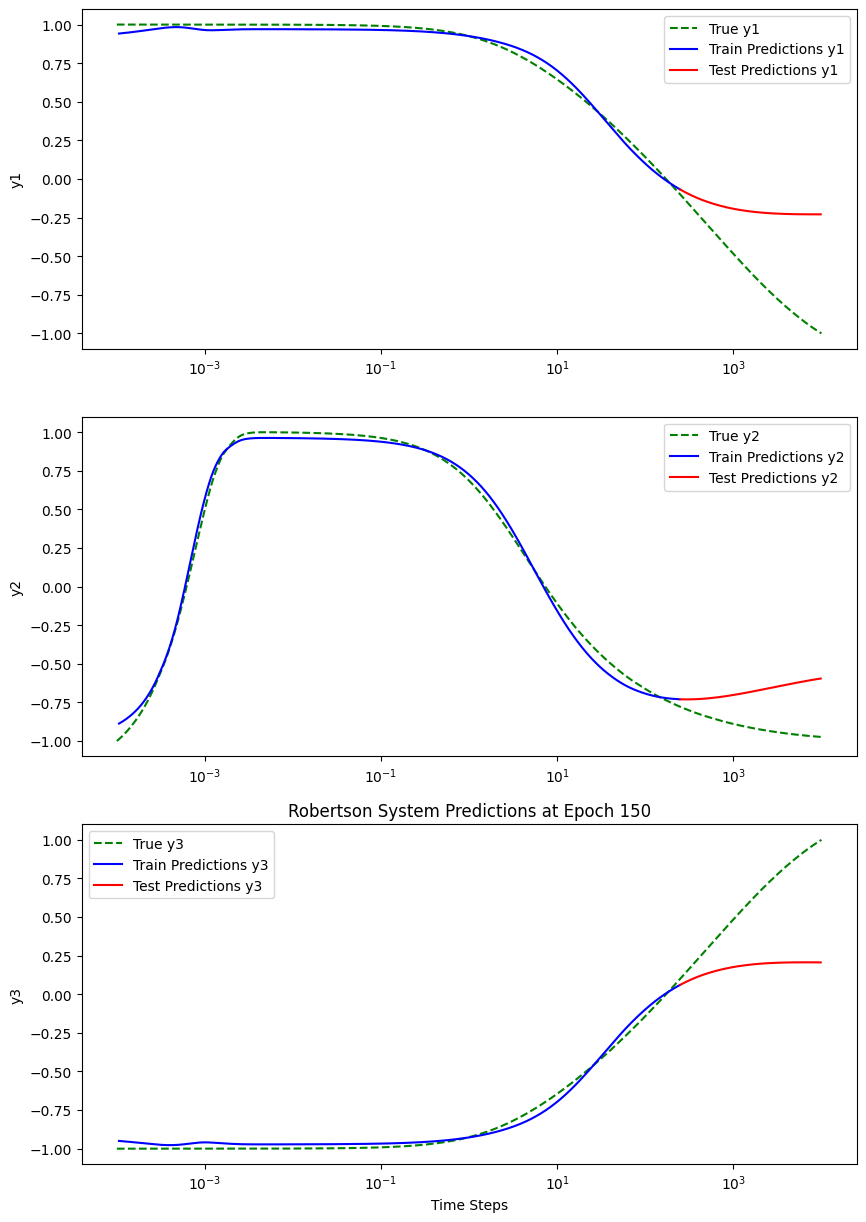

Epoch 151, Train Loss: 0.0014, Test Loss: 0.2026
Epoch 152, Train Loss: 0.0013, Test Loss: 0.2024
Epoch 153, Train Loss: 0.0013, Test Loss: 0.2022
Epoch 154, Train Loss: 0.0013, Test Loss: 0.2020
Epoch 155, Train Loss: 0.0013, Test Loss: 0.2018
Epoch 156, Train Loss: 0.0013, Test Loss: 0.2016
Epoch 157, Train Loss: 0.0012, Test Loss: 0.2013
Epoch 158, Train Loss: 0.0012, Test Loss: 0.2011
Epoch 159, Train Loss: 0.0012, Test Loss: 0.2008
Epoch 160, Train Loss: 0.0012, Test Loss: 0.2005
Epoch 161, Train Loss: 0.0012, Test Loss: 0.2003
Epoch 162, Train Loss: 0.0012, Test Loss: 0.2000
Epoch 163, Train Loss: 0.0011, Test Loss: 0.1997
Epoch 164, Train Loss: 0.0011, Test Loss: 0.1994
Epoch 165, Train Loss: 0.0011, Test Loss: 0.1990
Epoch 166, Train Loss: 0.0011, Test Loss: 0.1987
Epoch 167, Train Loss: 0.0011, Test Loss: 0.1984
Epoch 168, Train Loss: 0.0011, Test Loss: 0.1980
Epoch 169, Train Loss: 0.0010, Test Loss: 0.1977
Epoch 170, Train Loss: 0.0010, Test Loss: 0.1973
Epoch 171, Train Los

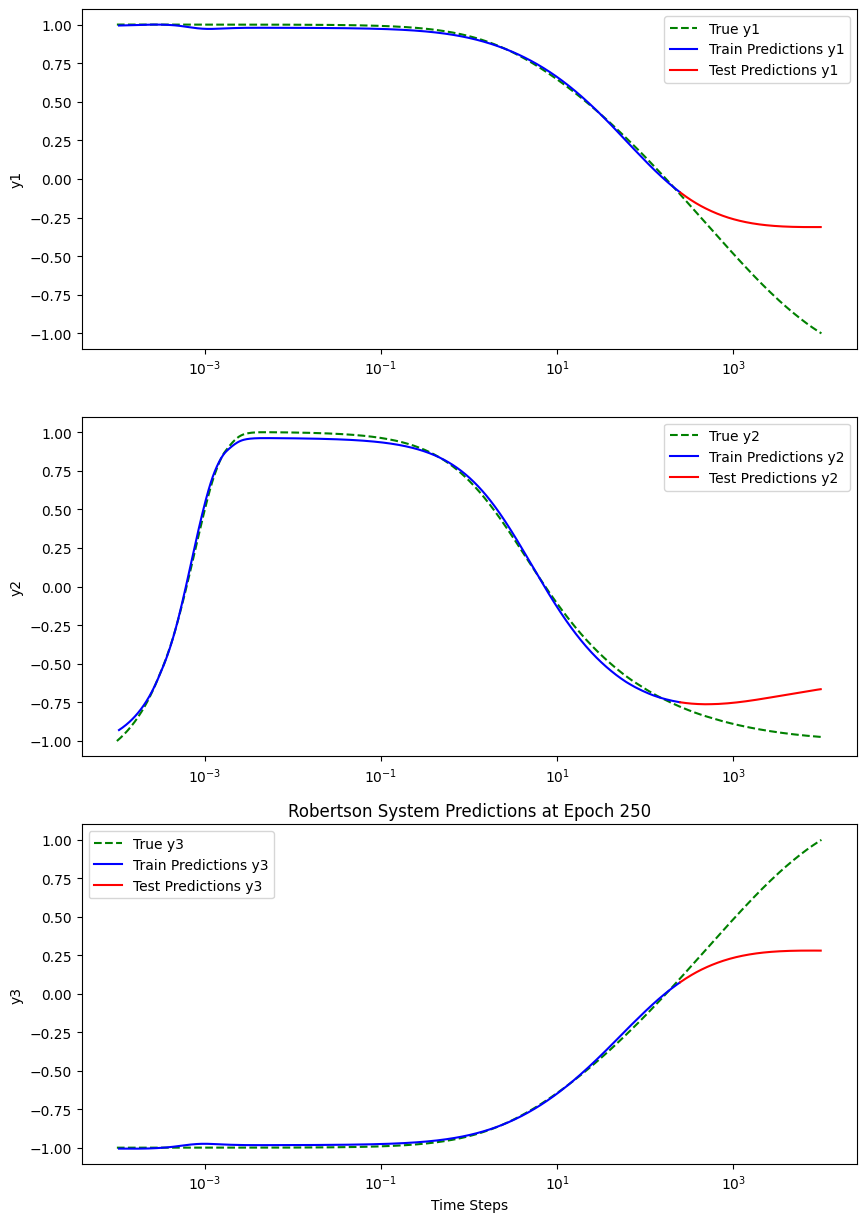

Epoch 251, Train Loss: 0.0004, Test Loss: 0.1510
Epoch 252, Train Loss: 0.0004, Test Loss: 0.1504
Epoch 253, Train Loss: 0.0004, Test Loss: 0.1498
Epoch 254, Train Loss: 0.0004, Test Loss: 0.1492
Epoch 255, Train Loss: 0.0004, Test Loss: 0.1487
Epoch 256, Train Loss: 0.0004, Test Loss: 0.1481
Epoch 257, Train Loss: 0.0004, Test Loss: 0.1475
Epoch 258, Train Loss: 0.0004, Test Loss: 0.1469
Epoch 259, Train Loss: 0.0004, Test Loss: 0.1463
Epoch 260, Train Loss: 0.0004, Test Loss: 0.1458
Epoch 261, Train Loss: 0.0004, Test Loss: 0.1452
Epoch 262, Train Loss: 0.0004, Test Loss: 0.1446
Epoch 263, Train Loss: 0.0004, Test Loss: 0.1441
Epoch 264, Train Loss: 0.0004, Test Loss: 0.1435
Epoch 265, Train Loss: 0.0004, Test Loss: 0.1430
Epoch 266, Train Loss: 0.0004, Test Loss: 0.1424
Epoch 267, Train Loss: 0.0004, Test Loss: 0.1419
Epoch 268, Train Loss: 0.0004, Test Loss: 0.1413
Epoch 269, Train Loss: 0.0003, Test Loss: 0.1408
Epoch 270, Train Loss: 0.0003, Test Loss: 0.1402
Epoch 271, Train Los

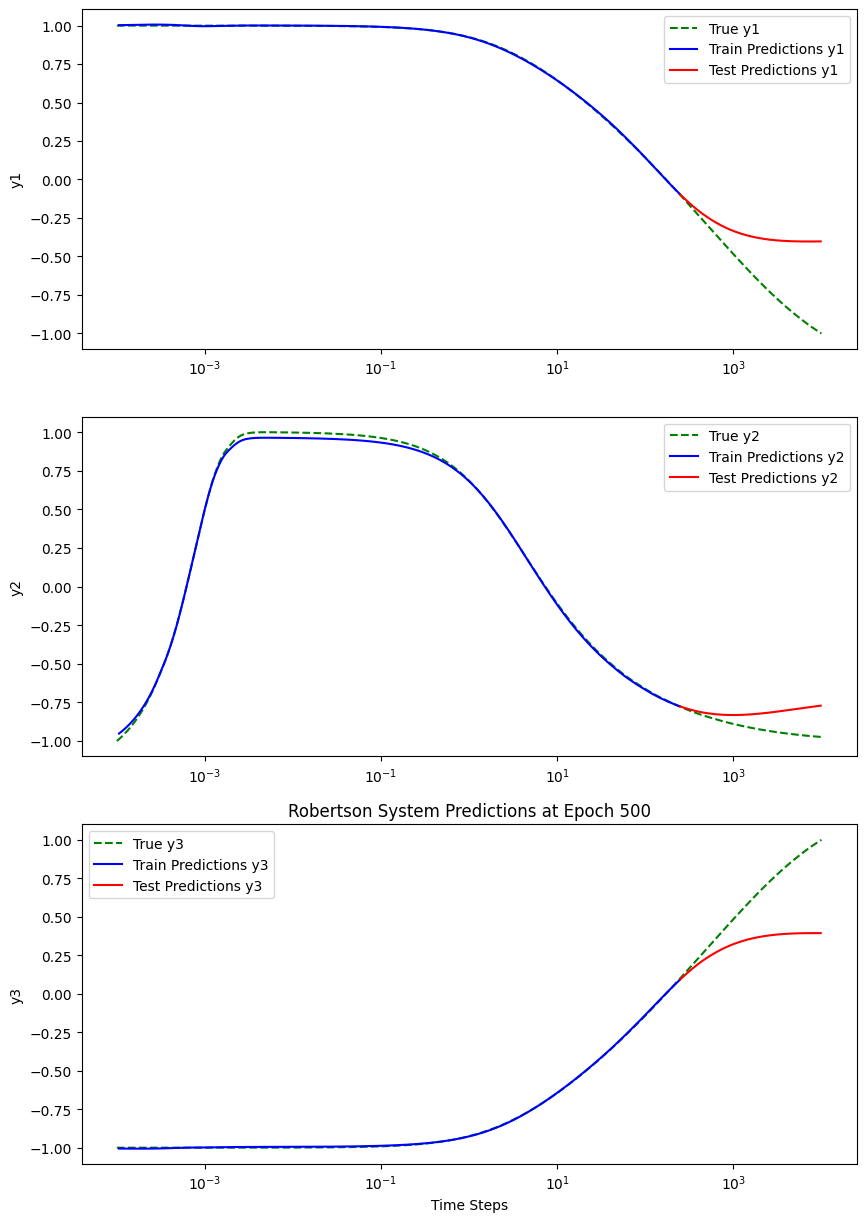

Train MAE: 0.0033, Train RMSE: 0.0056
Test MAE: 0.09313939, Test RMSE: 0.12232983


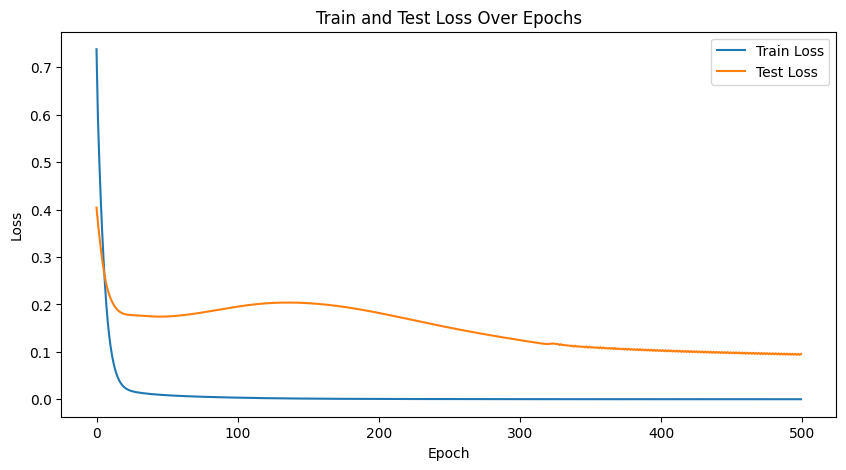

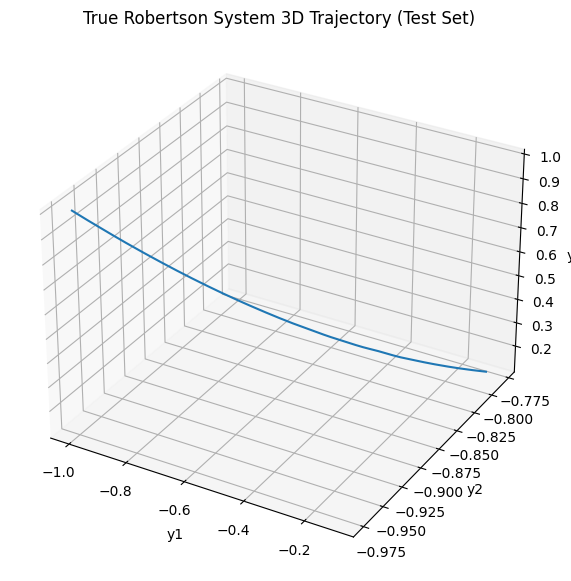

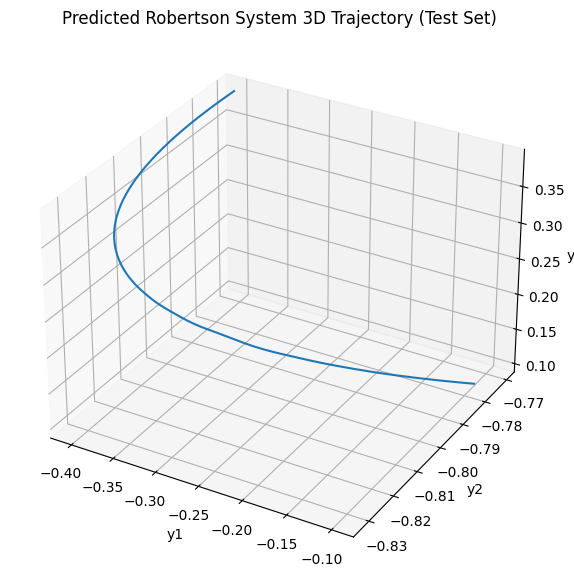

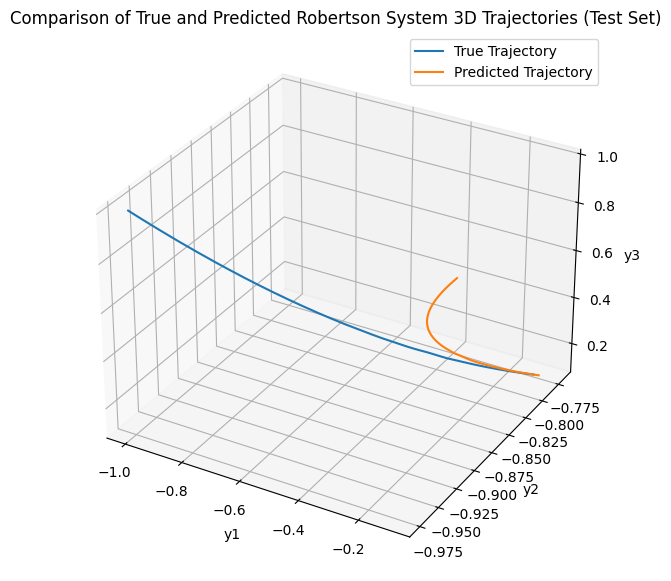

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

# Define the LSTM model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits=0, output_size=3, num_layers=2, backend='default.qubit'):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        if n_qubits > 0:
            print(f"Tagger will use Quantum LSTM running on backend {backend}")
            self.lstm = QLSTM(input_size, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_timestep_output = lstm_out[:, -1, :]  # Only use the last timestep output
        fc_out = self.fc(last_timestep_output)
        return fc_out

batch_size = 128

# Define hyperparameters and configurations
class Args:
    hidden_dim = 4
    n_qubits = 4
    n_epochs = 500
    backend = 'default.qubit'
    learning_rate = 0.001
    sequence_length = 4
    sample_size = 1000
    alpha = 0.99
    eps = 1e-8
    input_size = 3  # Input size is now 3 for y1, y2, and y3

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"LSTM hidden layer size: {args.hidden_dim}")
print(f"Number of qubits: {args.n_qubits}")
print(f"Training epochs: {args.n_epochs}")
print(f"Learning rate: {args.learning_rate}")
print(f"RMSprop alpha: {args.alpha}")
print(f"RMSprop eps: {args.eps}")
print(f"Sample size: {args.sample_size}")
print(f"Sequence length: {args.sequence_length}")
print(f"Input size: {args.input_size}")

# Robertson system parameters
def robertson(t, y):
    y1, y2, y3 = y
    dy1dt = -0.04 * y1 + 1e4 * y2 * y3
    dy2dt = 0.04 * y1 - 1e4 * y2 * y3 - 3e7 * y2**2
    dy3dt = 3e7 * y2**2
    return [dy1dt, dy2dt, dy3dt]

# Time span and time steps for the simulation
t_span = (1e-4, 10000)
t_eval = np.logspace(np.log10(t_span[0]), np.log10(t_span[1]), args.sample_size)

# Initial conditions
initial_state = [1, 0, 0]

# Solve the differential equation
sol = solve_ivp(robertson, t_span, initial_state, method='LSODA', t_eval=t_eval)

# Extracting the Robertson system data
y1, y2, y3 = sol.y

# Normalize the data
def normalize(data):
    data_min, data_max = np.min(data), np.max(data)
    return 2 * (data - data_min) / (data_max - data_min) - 1

y1_normalized = normalize(y1)
y2_normalized = normalize(y2)
y3_normalized = normalize(y3)

# Plotting each dimension of the Robertson system
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(t_eval, y1_normalized, label='y1')
plt.xlabel('Time')
plt.ylabel('y1')
plt.xscale('log')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(t_eval, y2_normalized, label='y2')
plt.xlabel('Time')
plt.ylabel('y2')
plt.xscale('log')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t_eval, y3_normalized, label='y3')
plt.xlabel('Time')
plt.ylabel('y3')
plt.xscale('log')
plt.legend()

plt.show()

# Plotting the 3D trajectory of the Robertson system
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y1_normalized, y2_normalized, y3_normalized)
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')
plt.title('Robertson System 3D Trajectory')
plt.show()

# Reshape the data for LSTM input
num_samples = len(t_eval) - args.sequence_length + 1

# Initialize data array
data = np.zeros((num_samples, args.sequence_length, args.input_size))

# Populate the data array with sequences of Robertson system values
for i in range(num_samples):
    data[i, :, 0] = y1_normalized[i:i + args.sequence_length]
    data[i, :, 1] = y2_normalized[i:i + args.sequence_length]
    data[i, :, 2] = y3_normalized[i:i + args.sequence_length]

# Convert to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32)

# Create dataset
input_sequences = data[:-1]  # All but the last sequence
labels = data[1:, -1, :]  # Labels are the next values in the sequence
dataset = TensorDataset(input_sequences, labels)

# Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Create subsets to maintain order
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits, output_size, backend):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim * sequence_length, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(x.size(0), -1)
        tag_space = self.fc(lstm_out)
        return tag_space

# Initialize the model
model = LSTMTagger(input_size=args.input_size, hidden_dim=args.hidden_dim,
                   sequence_length=args.sequence_length, n_qubits=args.n_qubits,
                   output_size=args.input_size, backend=args.backend).float().to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.learning_rate, alpha=args.alpha, eps=args.eps)

# Training loop with gradient clipping
train_losses = []
test_losses = []

for epoch in range(1, args.n_epochs + 1):
    model.train()
    epoch_train_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
        optimizer.step()

        epoch_train_losses.append(loss.item())

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Evaluation on test data using test_loader
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            epoch_test_losses.append(loss.item())

    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    if epoch in [5, 50, 100, 150, 250, 500]:
        model.eval()
        with torch.no_grad():
            train_preds = [model(batch[0].to(device)) for batch in train_loader]
            test_preds = [model(batch[0].to(device)) for batch in test_loader]

        train_preds = torch.cat(train_preds, dim=0)
        test_preds = torch.cat(test_preds, dim=0)

        x_original = t_eval

        fig, axs = plt.subplots(3, 1, figsize=(10, 15))

        # Plot true dynamics and predictions for y1
        axs[0].plot(x_original, y1_normalized, 'g--', label='True y1')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[0].plot(x_original[start_index:end_index], train_preds[:, 0].cpu().numpy(), 'b', label='Train Predictions y1')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[0].plot(x_original[start_index:end_index], test_preds[:, 0].cpu().numpy(), 'r', label='Test Predictions y1')
        axs[0].set_ylabel('y1')
        axs[0].set_xscale('log')
        axs[0].legend()

        # Plot true dynamics and predictions for y2
        axs[1].plot(x_original, y2_normalized, 'g--', label='True y2')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[1].plot(x_original[start_index:end_index], train_preds[:, 1].cpu().numpy(), 'b', label='Train Predictions y2')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[1].plot(x_original[start_index:end_index], test_preds[:, 1].cpu().numpy(), 'r', label='Test Predictions y2')
        axs[1].set_ylabel('y2')
        axs[1].set_xscale('log')
        axs[1].legend()

        # Plot true dynamics and predictions for y3
        axs[2].plot(x_original, y3_normalized, 'g--', label='True y3')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[2].plot(x_original[start_index:end_index], train_preds[:, 2].cpu().numpy(), 'b', label='Train Predictions y3')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[2].plot(x_original[start_index:end_index], test_preds[:, 2].cpu().numpy(), 'r', label='Test Predictions y3')
        axs[2].set_ylabel('y3')
        axs[2].set_xscale('log')
        axs[2].legend()

        plt.xlabel('Time Steps')
        plt.title(f'Robertson System Predictions at Epoch {epoch}')
        plt.show()

# Function to denormalize data
def denormalize(norm_data, original_min, original_max):
    return norm_data * (original_max - original_min) / 2 + (original_max + original_min) / 2

# Function to calculate metrics
def calculate_metrics(true_labels_np, predictions_np):
    mae = mean_absolute_error(true_labels_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(true_labels_np, predictions_np))
    return mae, rmse

# Final model evaluation
model.eval()
final_train_predictions = []
final_test_predictions = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_train_predictions.append(outputs)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_test_predictions.append(outputs)

# Concatenate the list of tensors into a single tensor
final_train_predictions = torch.cat(final_train_predictions, dim=0)
final_test_predictions = torch.cat(final_test_predictions, dim=0)

# Concatenate all the labels from the DataLoader
train_labels = torch.cat([label for _, label in train_loader], dim=0)
test_labels = torch.cat([label for _, label in test_loader], dim=0)

# Move predictions and labels to CPU and convert to numpy arrays for metrics calculation
train_labels_np = train_labels.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
final_train_predictions_np = final_train_predictions.cpu().numpy()
final_test_predictions_np = final_test_predictions.cpu().numpy()

# Denormalize predictions and true labels
train_labels_denorm = denormalize(train_labels_np, np.min(y1), np.max(y1))
test_labels_denorm = denormalize(test_labels_np, np.min(y1), np.max(y1))
final_train_predictions_denorm = denormalize(final_train_predictions_np, np.min(y1), np.max(y1))
final_test_predictions_denorm = denormalize(final_test_predictions_np, np.min(y1), np.max(y1))

# Calculate MAE and RMSE for both train and test sets
train_mae, train_rmse = calculate_metrics(train_labels_denorm, final_train_predictions_denorm)
test_mae, test_rmse = calculate_metrics(test_labels_denorm, final_test_predictions_denorm)

# Output the metrics for denormalized predictions
print(f'Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}')
print(f'Test MAE: {test_mae:.8f}, Test RMSE: {test_rmse:.8f}')

# Plotting the overall training and test losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the 3D trajectory of the real values for the test set
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_labels_np[:, 0], test_labels_np[:, 1], test_labels_np[:, 2], label='True Trajectory')
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')
plt.title('True Robertson System 3D Trajectory (Test Set)')
plt.show()

# Plotting the 3D trajectory of the final test predictions
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(final_test_predictions_np[:, 0], final_test_predictions_np[:, 1], final_test_predictions_np[:, 2], label='Predicted Trajectory')
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')
plt.title('Predicted Robertson System 3D Trajectory (Test Set)')
plt.show()

# Plotting the comparison of the real and predicted 3D trajectories for the test set
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_labels_np[:, 0], test_labels_np[:, 1], test_labels_np[:, 2], label='True Trajectory')
ax.plot(final_test_predictions_np[:, 0], final_test_predictions_np[:, 1], final_test_predictions_np[:, 2], label='Predicted Trajectory')
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')
ax.legend()
plt.title('Comparison of True and Predicted Robertson System 3D Trajectories (Test Set)')
plt.show()









In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals

# Robertson system parameters
def robertson(t, y):
    y1, y2, y3 = y
    dy1dt = -0.04 * y1 + 1e4 * y2 * y3
    dy2dt = 0.04 * y1 - 1e4 * y2 * y3 - 3e7 * y2**2
    dy3dt = 3e7 * y2**2
    return [dy1dt, dy2dt, dy3dt]

# Jacobian of the Robertson system
def jacobian(y):
    y1, y2, y3 = y
    J = np.array([
        [-0.04, 1e4 * y3, 1e4 * y2],
        [0.04, -1e4 * y3 - 6e7 * y2, -1e4 * y2],
        [0, 6e7 * y2, 0]
    ])
    return J

# Initial conditions
initial_state = [1, 0, 0]

# Time span and time steps for the simulation
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the differential equation
sol = solve_ivp(robertson, t_span, initial_state, method='LSODA', t_eval=t_eval)

# Extracting the Robertson system data at the final state
final_state = sol.y[:, -1]

# Compute the Jacobian at the final state
J = jacobian(final_state)

# Compute the eigenvalues of the Jacobian
eigenvalues = eigvals(J)

# Calculate the stiffness ratio
stiffness_ratio = max(abs(eigenvalues)) / min(abs(eigenvalues))

# Output the eigenvalues and stiffness ratio
print("Eigenvalues of the Jacobian at the final state:")
print(eigenvalues)
print("Stiffness ratio:", stiffness_ratio)



Eigenvalues of the Jacobian at the final state:
[-4.19784307e+03  2.41126563e-16 -8.92381685e-03]
Stiffness ratio: 1.7409293339402158e+19
